In [121]:
import networkx as nx
import matplotlib.pyplot as plt

def generate_graph_plot(data_string):
    lines = data_string.strip().split('\n')

    header = lines[0].split()
    n_edges = int(header[1])

    edge_lines = lines[1 : 1 + n_edges]
    node_lines = lines[1 + n_edges : -1]
    
    path_info = lines[-1].split()
    start_node = path_info[0]
    end_node = path_info[1]

    G = nx.DiGraph()

    for line in edge_lines:
        parts = line.split()
        u, v, w = parts[0], parts[1], int(parts[2])
        G.add_edge(u, v, weight=w)

    for line in node_lines:
        parts = line.split()
        node = parts[0]
        h_value = int(parts[1])
        if node not in G:
            G.add_node(node)
        G.nodes[node]['h'] = h_value

    layers = {n: 0 for n in G.nodes()}
    
    try:
        sorted_nodes = list(nx.topological_sort(G))
        for node in sorted_nodes:
            current_depth = layers[node]
            for child in G.successors(node):
                if layers[child] < current_depth + 1:
                    layers[child] = current_depth + 1
    except nx.NetworkXUnfeasible:
        pass

    for node, depth in layers.items():
        G.nodes[node]['subset'] = depth

    node_colors = []
    for n in G.nodes():
        if n == start_node:
            node_colors.append("orange")
        elif n == end_node:
            node_colors.append("red")
        else:
            node_colors.append('lightblue')

    node_labels = {}
    for n in G.nodes():
        h_val = G.nodes[n].get('h', '?')
        node_labels[n] = f"{n}\n(h={h_val})"
        
    edge_labels = nx.get_edge_attributes(G, "weight")

    fig, ax = plt.subplots(figsize=(14, 8))
    
    pos = nx.multipartite_layout(G, subset_key='subset')
    
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1500, ax=ax)    
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrowsize=20, ax=ax)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, ax=ax)
    
    ax.set_title(f"Graph Visualization: {start_node} to {end_node}")
    ax.axis('off')
    
    return fig

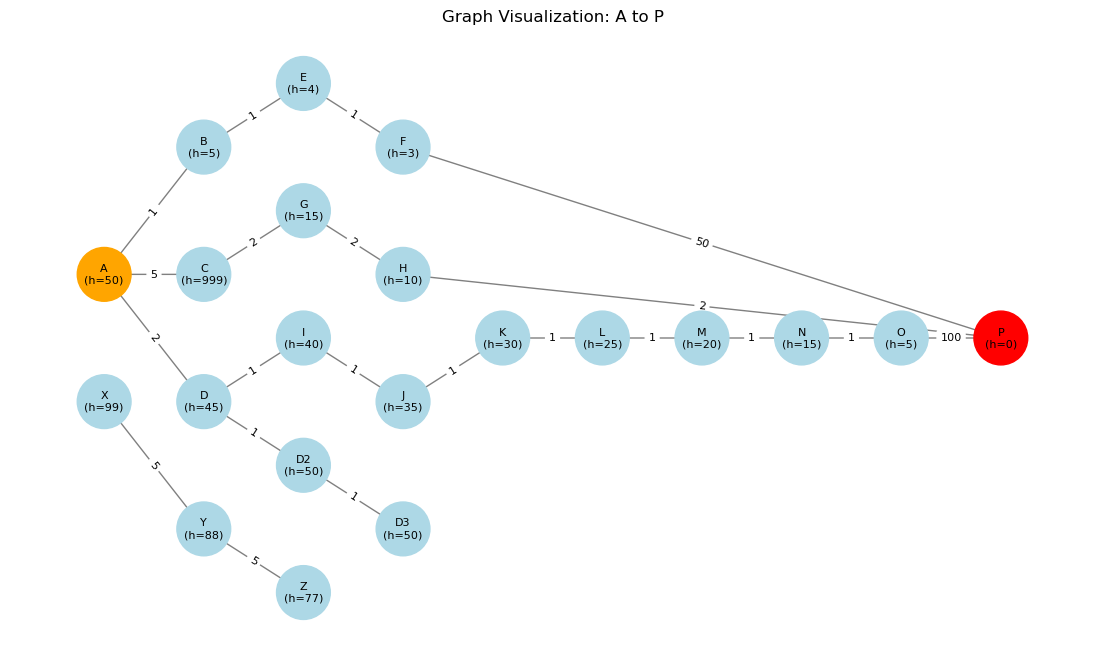

In [131]:
raw_data = """19 21
A B 1
A C 5
A D 2
B E 1
E F 1
F P 50
C G 2
G H 2
H P 2
D I 1
I J 1
J K 1
K L 1
L M 1
M N 1
N O 1
O P 100
D D2 1
D2 D3 1
X Y 5
Y Z 5
A 50
B 5
C 999
D 45
E 4
F 3
G 15
H 10
I 40
J 35
K 30
L 25
M 20
N 15
O 5
D2 50
D3 50
P 0
X 99
Y 88
Z 77
A P"""

fig = generate_graph_plot(raw_data)
plt.show()

In [132]:
import heapq

In [133]:
def solve_a_star(data):
    lines = data.strip().split("\n")
    n_edges = int(lines[0].split()[1])
    edge_lines = lines[1:1 + n_edges]
    node_lines = lines[1 + n_edges: -1]
    
    start, end = lines[-1].split()
    
    graph = {}
    heuristics = {}

    for line in node_lines:
        edge_name, heuristic_weight = line.split()
        heuristics[edge_name] = int(heuristic_weight)

    for line in edge_lines:
        u, v, w = line.split()
        if u not in graph:
            graph[u] = []
        graph[u].append((v, int(w)))

    start_f = 0 + heuristics.get(start, 0)
    pq = [(start_f, start)]
    cost_so_far = {start: 0}
    came_from = {start: None}

    #A-star = g + h
    while pq:
        current_f, current_node = heapq.heappop(pq)

        if current_node == end:
            #Success!
            break

        best_known_g = cost_so_far[current_node]
        best_known_f = best_known_g + heuristics.get(current_node, 0)
                
        if current_f > best_known_f:
            continue
    
        for n, weight in graph.get(current_node, []): #n for neighbor
            new_g = cost_so_far[current_node] + weight

            if new_g < cost_so_far.get(n, float('inf')):
                cost_so_far[n] = new_g
                came_from[n] = current_node

                #highlight of A*:
                new_f = new_g + heuristics.get(n, 0)
                heapq.heappush(pq, (new_f, n))
    
    path = []
    if end in came_from:
        current = end
        while current:
            path.append(current)
            current = came_from[current]
        path.reverse()

    return path, cost_so_far    

In [134]:
optimal_path, total_cost = solve_a_star(raw_data)

In [136]:
optimal_path, total_cost

(['A', 'B', 'E', 'F', 'P'],
 {'A': 0,
  'B': 1,
  'C': 5,
  'D': 2,
  'E': 2,
  'F': 3,
  'P': 53,
  'I': 3,
  'D2': 3,
  'J': 4,
  'K': 5,
  'L': 6,
  'M': 7,
  'N': 8,
  'O': 9,
  'D3': 4})

In [137]:
def highlight_path_in_data(original_data, path):
    mapping = {node: f"*{node}*" for node in path}
    new_lines = []
    
    for line in original_data.strip().split('\n'):
        parts = line.split()
        new_parts = []
        for word in parts:
            if word in mapping:
                new_parts.append(mapping[word])
            else:
                new_parts.append(word)
        new_lines.append(" ".join(new_parts))

    return "\n".join(new_lines)    

In [138]:
highlighted_data = highlight_path_in_data(raw_data, optimal_path)

In [139]:
highlighted_data

'19 21\n*A* *B* 1\n*A* C 5\n*A* D 2\n*B* *E* 1\n*E* *F* 1\n*F* *P* 50\nC G 2\nG H 2\nH *P* 2\nD I 1\nI J 1\nJ K 1\nK L 1\nL M 1\nM N 1\nN O 1\nO *P* 100\nD D2 1\nD2 D3 1\nX Y 5\nY Z 5\n*A* 50\n*B* 5\nC 999\nD 45\n*E* 4\n*F* 3\nG 15\nH 10\nI 40\nJ 35\nK 30\nL 25\nM 20\nN 15\nO 5\nD2 50\nD3 50\n*P* 0\nX 99\nY 88\nZ 77\n*A* *P*'

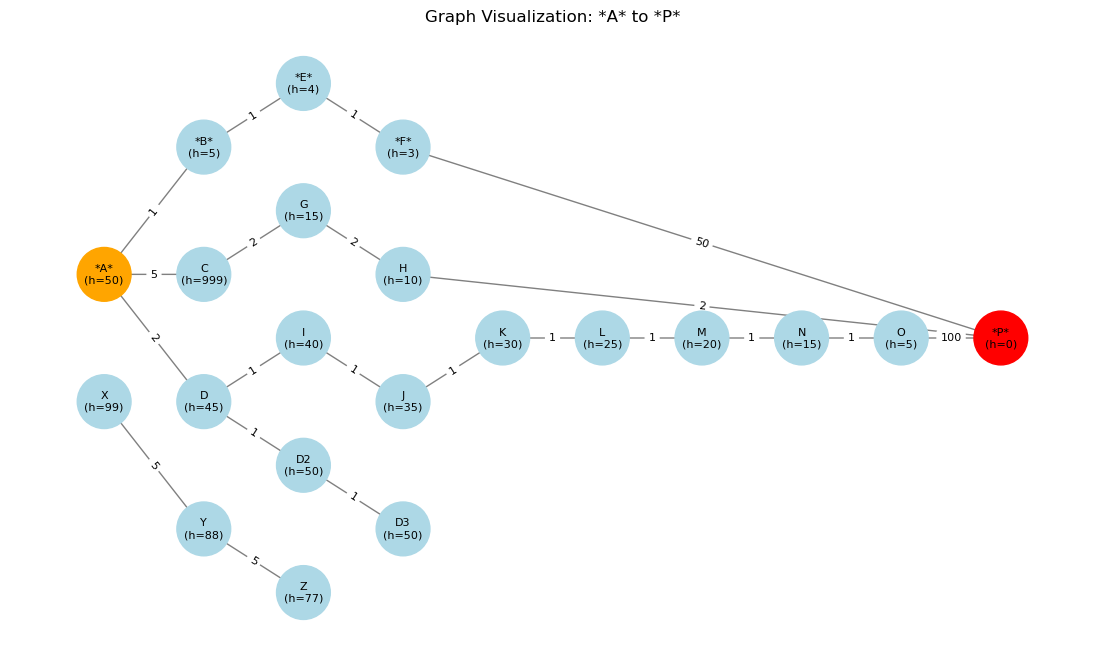

In [140]:
fig = generate_graph_plot(highlighted_data)